In [83]:
import pandas as pd
data = pd.read_csv('./train/0a56673739e7f627226a.csv')
data.describe()

,部件工作时长,累积量参数1,累积量参数2,转速信号1,转速信号2,压力信号1,压力信号2,温度信号,流量信号,电流信号,开关1信号,开关2信号,告警信号1
count,5191.000000,5191.000000,5191.000000,5191.000000,5191.000000,5191.000000,5191.000000,5191.000000,5191.000000,5191.000000,5191.000000,5191.0,5191.000000
mean,566.678434,7175.246388,8013.669813,7674.937893,16997.236199,147.117087,337.977711,46.748334,45.664864,852.677201,0.433828,0.0,0.000771
std,307.052829,3993.475850,4415.227079,2466.874204,6223.720498,91.010549,48.653477,6.942626,26.034643,357.864710,0.495650,0.0,0.027751
min,0.000000,0.000000,0.000000,0.400000,0.020000,11.030000,0.010000,19.400000,0.000000,0.000000,0.000000,0.0,0.000000
25%,323.250000,3954.500000,4472.000000,5251.470000,11869.730000,77.740000,336.905000,42.600000,28.225000,620.120000,0.000000,0.0,0.000000
50%,590.750000,7232.500000,8196.500000,6611.320000,14907.430000,79.680000,346.110000,46.500000,45.150000,620.260000,0.000000,0.0,0.000000
75%,819.750000,10609.500000,11778.000000,10058.125000,22740.180000,234.385000,351.050000,51.200000,55.865000,1221.435000,1.000000,0.0,0.000000
max,1102.750000,13860.000000,15463.500000,12675.920000,28490.290000,971.070000,453.990000,69.300000,138.500000,1649.490000,1.000000,0.0,1.000000


In [84]:
data.head(10)

,部件工作时长,累积量参数1,累积量参数2,转速信号1,转速信号2,压力信号1,压力信号2,温度信号,流量信号,电流信号,开关1信号,开关2信号,告警信号1,设备类型
0,0.0,0.0,0.0,5268.92,601.61,79.78,226.39,38.8,137.23,620.27,0.0,0.0,0.0,S26a
1,0.0,0.0,0.0,5264.30,604.04,78.60,226.14,38.8,133.86,620.17,0.0,0.0,0.0,S26a
2,0.0,0.0,0.0,5268.55,604.56,78.03,225.76,38.8,133.85,620.15,0.0,0.0,0.0,S26a
3,0.0,0.0,0.0,5268.45,604.17,77.95,226.84,38.8,133.37,620.23,0.0,0.0,0.0,S26a
4,0.0,0.0,0.0,5254.11,11871.25,77.59,353.67,38.8,136.17,620.13,0.0,0.0,0.0,S26a
5,0.0,0.0,0.0,5260.92,11872.80,79.08,353.99,38.8,136.60,620.23,0.0,0.0,0.0,S26a
6,0.0,0.0,0.0,5261.22,11872.99,78.06,353.44,38.8,131.71,620.23,0.0,0.0,0.0,S26a
7,0.0,0.0,0.0,5251.34,11870.60,78.30,353.76,38.8,137.57,620.27,0.0,0.0,0.0,S26a
8,0.0,0.0,0.0,5252.41,11871.61,79.28,353.35,38.8,131.92,620.05,0.0,0.0,0.0,S26a
9,0.0,0.0,0.0,5243.44,11869.17,76.72,353.22,38.8,137.58,620.13,0.0,0.0,0.0,S26a


In [1]:
import os
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
from multiprocessing import Pool
from sklearn.model_selection import KFold
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
idx='train_file_name'
ycol='life'

In [3]:
#获取数据文件地址
def getfilelist(dir,filelist):
    newdir = dir
    if os.path.isfile(dir):
        filelist.append(dir)
    elif os.path.isdir(dir):
        for s in os.listdir(dir):
            newdir = os.path.join(dir,s)
            filelist.append(newdir)
#             getfilelist(newdir,filelist)
    return filelist

In [4]:
#处理统计数据
def stat(data,c,name):
        
        if data.min() > 0:
            c[name + '_min'] = data.min()
        else:
            c[name + '_min'] = 0
        if data.mean() > 0:
            c[name + '_mean'] = data.mean()
        else:
            c[name + '_mean'] = 0
        if data.median() > 0:
            c[name + '_median'] = data.median()
        else:
            c[name + '_median'] = 0
        c[name + '_max'] = data.max()
        c[name + '_count'] = data.count()
        c[name + '_ptp'] = data.ptp()
        c[name + '_std'] = data.std()
        return c

In [12]:
def process_sample_single(file,train_p):
    data = pd.read_csv(file)
    lifemax = data['部件工作时长'].max()
    data = data[data['部件工作时长']<=lifemax*train_p]
#     data = data.reset_index()
#     openup10 = [] 
#     openup00 = [] 
#     openup11 = []
#     for i in range(len(data)):
#         if data['开关1信号'][i]==0 and data['开关2信号'][i]==0:
#             openup00.append(1)
#             openup10.append(0)
#             openup11.append(0)
#         elif data['开关1信号'][i]==1 and data['开关2信号'][i]==1:
#             openup00.append(0)
#             openup10.append(0)
#             openup11.append(1)
#         else:
#             openup00.append(0)
#             openup10.append(1)
#             openup11.append(0)
#          '开关1开关2_11':sum(openup11),
#          '开关1开关2_10':sum(openup10),
#          '开关1开关2_00':sum(openup00),
    c = {'train_file_name':os.path.basename(file)+str(train_p),
        '开关1_sum':data['开关1信号'].sum(),
        '开关2_sum':data['开关2信号'].sum(),
        '告警1_sum':data['告警信号1'].sum(),
        '设备类型':data['设备类型'][0],
        'life':lifemax - data['部件工作时长'].max()
        }
    for i in ['部件工作时长', 
              '累积量参数1', 
              '累积量参数2',
              '转速信号1',
              '转速信号2',
              '压力信号1',
              '压力信号2',
              '温度信号',
              '流量信号',
              '电流信号']:
        c = stat(data[i],c,i)
    features_csv = pd.DataFrame(c,index=[0])
    return features_csv

In [23]:
data = process_sample_single('./train/0a56673739e7f627226a.csv',1)
data

/public/home/wenyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  import sys


,train_file_name,开关1_sum,开关2_sum,告警1_sum,设备类型,life,部件工作时长_max,部件工作时长_min,部件工作时长_count,部件工作时长_mean,部件工作时长_ptp,部件工作时长_std,累积量参数1_max,累积量参数1_min,累积量参数1_count,累积量参数1_mean,累积量参数1_ptp,累积量参数1_std,累积量参数2_max,累积量参数2_min,累积量参数2_count,累积量参数2_mean,累积量参数2_ptp,累积量参数2_std,转速信号1_max,转速信号1_min,转速信号1_count,转速信号1_mean,转速信号1_ptp,转速信号1_std,转速信号2_max,转速信号2_min,转速信号2_count,转速信号2_mean,转速信号2_ptp,转速信号2_std,压力信号1_max,压力信号1_min,压力信号1_count,压力信号1_mean,压力信号1_ptp,压力信号1_std,压力信号2_max,压力信号2_min,压力信号2_count,压力信号2_mean,压力信号2_ptp,压力信号2_std,温度信号_max,温度信号_min,温度信号_count,温度信号_mean,温度信号_ptp,温度信号_std,流量信号_max,流量信号_min,流量信号_count,流量信号_mean,流量信号_ptp,流量信号_std,电流信号_max,电流信号_min,电流信号_count,电流信号_mean,电流信号_ptp,电流信号_std
0,0a56673739e7f627226a.csv1,2252.0,0.0,4.0,S26a,0.0,1102.75,0.0,5191,566.678434,1102.75,307.052829,13860.0,0.0,5191,7175.246388,13860.0,3993.47585,15463.5,0.0,5191,8013.669813,15463.5,4415.227079,12675.92,0.4,5191,7674.937893,12675.52,2466.874204,28490.29,0.02,5191,16997.236199,28490.27,6223.720498,971.07,11.03,5191,147.117087,960.04,91.010549,453.99,0.01,5191,337.977711,453.98,48.653477,69.3,19.4,5191,46.748334,49.9,6.942626,138.5,0.0,5191,45.664864,138.5,26.034643,1649.49,0.0,5191,852.677201,1649.49,357.86471


In [41]:
def get_together(cpu_num,list_dir,istest,func):
    if istest:
        train_p_list = [1]
        rst = []
        pool = Pool(cpu_num)
        for e in list_dir:
            for train_p in train_p_list:
                rst.append(pool.apply_async(func,args=(e,train_p,)))
        pool.close()
        pool.join()
        rst = [i.get() for i in rst]
        tv_features = rst[0]
        for i in rst[1:]:
            tv_features = pd.concat([tv_features,i],axis=0)
        cols = tv_features.columns.tolist()
        for col in [idx,ycol]:
            cols.remove(col)
        cols = [idx] + cols + [ycol]
        tv_features[idx] = tv_features[idx].apply(lambda x:x[:-1] )
        tv_features = tv_features.reindex(columns=cols)
    else:
        #[0.35,0.45,0.55,0.65,0.75,0.85]
        train_p_list = [0.45,0.55,0.63,0.75,0.85]
        rst = []
        pool = Pool(cpu_num)
        for e in list_dir:
            for train_p in train_p_list:
                rst.append(pool.apply_async(func,args=(e,train_p,)))
        pool.close()
        pool.join()
        rst = [i.get() for i in rst]
        tv_features = rst[0]
        for i in rst[1:]:
            tv_features = pd.concat([tv_features,i],axis=0)
        cols = tv_features.columns.tolist()
        for col in [idx,ycol]:
            cols.remove(col)
        cols = [idx] + cols + [ycol]
        tv_features = tv_features.reindex(columns=cols)
        
    return tv_features

In [6]:
def compute_loss(target,predict):
    temp = np.log(abs(target+1)) - np.log(abs(predict+1))
    loss = np.sqrt(np.dot(temp,temp)/len(temp))
    return loss

In [7]:
#linear
def linear_cv(train,test,params,feature_names,nfold,seed):
    loss = 0
    train_pred = pd.DataFrame({'true':train[ycol],'pred':np.zeros(len(train))})
    test_pred = pd.DataFrame({idx:test[idx],ycol:np.zeros(len(test))},columns=[idx,ycol])
    kfolder = KFold(n_splits=nfold,shuffle=True,random_state=seed)
    for fold_id,(trn_idx,val_idx) in enumerate(kfolder.split(train)):
        print(f'\nFold_{fold_id} Training ================================\n')
        svr_trnX = train.iloc[trn_idx][feature_names]
        svr_trnY = train.iloc[trn_idx][ycol]
        svr_valX = train.iloc[val_idx][feature_names]
        svr_valY = train.iloc[val_idx][ycol]
        clf = linear_model.Lasso(alpha = 0.1)
        clf.fit(svr_trnX,svr_trnY)
        val_pred = clf.predict(svr_valX)
        train_pred.loc[val_idx,'pred'] = val_pred
        test_pred[ycol] += clf.predict(test[feature_names]) / nfold
    loss = compute_loss(train_pred['true'],train_pred['pred'])
    print('\nCV LOSS:', loss)
    return test_pred

In [8]:
#svm
def svr_cv(train,test,params,feature_names,nfold,seed):
    loss = 0
    train_pred = pd.DataFrame({'true':train[ycol],'pred':np.zeros(len(train))})
    test_pred = pd.DataFrame({idx:test[idx],ycol:np.zeros(len(test))},columns=[idx,ycol])
    kfolder = KFold(n_splits=nfold,shuffle=True,random_state=seed)
    for fold_id,(trn_idx,val_idx) in enumerate(kfolder.split(train)):
        print(f'\nFold_{fold_id} Training ================================\n')
        svr_trnX = train.iloc[trn_idx][feature_names]
        svr_trnY = train.iloc[trn_idx][ycol]
        svr_valX = train.iloc[val_idx][feature_names]
        svr_valY = train.iloc[val_idx][ycol]
        clf = SVR(gamma='scale', C=5.0, epsilon=0.02)
        clf.fit(svr_trnX,svr_trnY)
        val_pred = clf.predict(svr_valX)
        train_pred.loc[val_idx,'pred'] = val_pred
        test_pred[ycol] += clf.predict(test[feature_names]) / nfold
    loss = compute_loss(train_pred['true'],train_pred['pred'])
    print('\nCV LOSS:', loss)
    return test_pred

In [31]:
#lightgbm
def lgb_cv(train, params, fit_params,feature_names, nfold, seed,test):
    train_pred = pd.DataFrame({
        'true': train[ycol],
        'pred': np.zeros(len(train))})
    test_pred = pd.DataFrame({idx: test[idx], ycol: np.zeros(len(test))},columns=[idx,ycol])
    kfolder = KFold(n_splits=nfold, shuffle=True, random_state=seed)
    for fold_id, (trn_idx, val_idx) in enumerate(kfolder.split(train)):
        print(f'\nFold_{fold_id} Training ================================\n')
        lgb_trn = lgb.Dataset(
            data=train.iloc[trn_idx][feature_names],
            label=train.iloc[trn_idx][ycol],
            feature_name=feature_names)
        lgb_val = lgb.Dataset(
            data=train.iloc[val_idx][feature_names],
            label=train.iloc[val_idx][ycol],
            feature_name=feature_names)
        lgb_reg = lgb.train(params=params, train_set=lgb_trn, **fit_params,
                  valid_sets=[lgb_trn, lgb_val])
        val_pred = lgb_reg.predict(
            train.iloc[val_idx][feature_names])
        train_pred.loc[val_idx, 'pred'] = val_pred
        test_pred[ycol] += lgb_reg.predict(test[feature_names]) / nfold
    print(pd.DataFrame({
        'column': feature_names,
        'importance': lgb_reg.feature_importance(),
    }).sort_values(by='importance'))
    score = compute_loss(train_pred['true'], train_pred['pred'])
    print('\nCV LOSS:', score)
    return test_pred

In [39]:
params_lgb = {'num_leaves': 15, 
              'max_depth':4, 
              'learning_rate': 0.08,
              'objective': 'regression', 
              'boosting': 'gbdt',
                'n_jobs':8,
                "metric": 'rmse',
                 'lambda_l2': 0.1,
              'verbosity': -1}

fit_params_lgb = {'num_boost_round': 5000, 
                  'verbose_eval':200
}

In [42]:
start = time.time()
list_dir_tr = getfilelist('./train/',[])
list_dir_te = getfilelist('./test1/',[])
func = process_sample_single
test = get_together(15,list_dir_te,True,func)
train = get_together(15,list_dir_tr,False,func)
train_test=pd.concat([train,test],join='outer',axis=0).reset_index(drop=True)
train_test = pd.get_dummies(train_test,columns=['设备类型'])
# feature_name=list(filter(lambda x:x not in[idx,ycol],train_test.columns))

In [22]:
feature_name=list(filter(lambda x:x not in[idx,ycol],train_test.columns))

In [43]:
feature_name_lgb=list(filter(lambda x:x in['部件工作时长_max','部件工作时长_mean'],train_test.columns))
sub= lgb_cv(train_test.iloc[:train.shape[0]] ,params_lgb, fit_params_lgb, 
                feature_name, 5,2018,train_test.iloc[train.shape[0]:])

sub.to_csv('baseline_sub1.csv',index=False)
print("process(es) done.", start - time.time())


Fold_0 Training ================================

[200]	training's rmse: 624.259	valid_1's rmse: 911.777
[400]	training's rmse: 446.161	valid_1's rmse: 857.324
[600]	training's rmse: 334.519	valid_1's rmse: 824.34
[800]	training's rmse: 266.219	valid_1's rmse: 807.808
[1000]	training's rmse: 215.752	valid_1's rmse: 795.282
[1200]	training's rmse: 179.194	valid_1's rmse: 784.421
[1400]	training's rmse: 148.002	valid_1's rmse: 777.854
[1600]	training's rmse: 125.678	valid_1's rmse: 774.31
[1800]	training's rmse: 104.93	valid_1's rmse: 770.793
[2000]	training's rmse: 89.528	valid_1's rmse: 768.18
[2200]	training's rmse: 76.4331	valid_1's rmse: 765.864
[2400]	training's rmse: 65.8327	valid_1's rmse: 764.179
[2600]	training's rmse: 57.2279	valid_1's rmse: 763.005
[2800]	training's rmse: 49.8682	valid_1's rmse: 761.914
[3000]	training's rmse: 43.9038	valid_1's rmse: 761.124
[3200]	training's rmse: 38.5133	valid_1's rmse: 760.391
[3400]	training's rmse: 33.7229	valid_1's rmse: 759.712
[3600]

In [46]:
#['部件工作时长_max','部件工作时长_mean'] 0.780
feature_name_svr=list(filter(lambda x:x in['部件工作时长_max','部件工作时长_mean'],train_test.columns))
sub= svr_cv(train_test.iloc[:train.shape[0]],train_test.iloc[train.shape[0]:] ,params_lgb, 
                feature_name_svr, 5,2018)
sub.to_csv('baseline_sub3.csv',index=False)


Fold_0 Training ================================


Fold_1 Training ================================


Fold_2 Training ================================


Fold_3 Training ================================


Fold_4 Training ================================


CV LOSS: 0.7068698923450559


In [45]:
feature_name_linear=list(filter(lambda x:x in['部件工作时长_max','部件工作时长_mean'],train_test.columns))
sub= linear_cv(train_test.iloc[:train.shape[0]],train_test.iloc[train.shape[0]:] ,params_lgb, 
                feature_name_linear, 5,2018)
# sub.to_csv('baseline_sub2.csv',index=False)


Fold_0 Training ================================


Fold_1 Training ================================


Fold_2 Training ================================


Fold_3 Training ================================


Fold_4 Training ================================


CV LOSS: 0.8402007848638722


In [123]:
train_test.describe()

,开关1_sum,开关2_sum,告警1_sum,部件工作时长_min,部件工作时长_mean,部件工作时长_median,部件工作时长_max,部件工作时长_count,部件工作时长_ptp,部件工作时长_std,...,电流信号_max,电流信号_count,电流信号_ptp,电流信号_std,life,设备类型_S100,设备类型_S26a,设备类型_S508,设备类型_S51d,设备类型_Saa3
count,6373.000000,6373.000000,6373.000000,6373.0,6373.000000,6373.000000,6373.000000,6.373000e+03,6373.000000,6373.000000,...,6373.000000,6.373000e+03,6373.000000,6373.000000,6373.000000,6373.000000,6373.000000,6373.000000,6373.000000,6373.000000
mean,6731.734191,2.705162,663.414091,0.0,1088.925602,1087.230053,2239.689628,1.803861e+04,2376.850816,662.115364,...,1703.847014,1.803861e+04,1696.573747,404.791014,1277.797270,0.155029,0.586694,0.011298,0.205084,0.041895
std,18753.760268,69.705417,4516.771592,0.0,1165.501067,1177.957576,2355.791895,3.335097e+04,2626.699242,694.499573,...,253.565454,3.335097e+04,267.370066,103.711547,1653.710068,0.361961,0.492465,0.105697,0.403795,0.200366
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000,...,1178.290000,3.000000e+00,0.190000,0.100167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1219.000000,0.000000,38.000000,0.0,259.820275,253.000000,547.250000,4.029000e+03,572.500000,165.147447,...,1612.300000,4.029000e+03,1612.300000,344.331342,180.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3277.000000,0.000000,142.000000,0.0,710.024901,700.000000,1486.750000,1.060700e+04,1542.500000,445.239064,...,1658.770000,1.060700e+04,1655.700000,395.067415,662.500000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,7031.000000,0.000000,467.000000,0.0,1540.429116,1528.750000,3155.000000,2.204000e+04,3260.750000,928.228708,...,1683.570000,2.204000e+04,1683.540000,445.669210,1787.500000,0.000000,1.000000,0.000000,0.000000,0.000000
max,364613.000000,2980.000000,148027.000000,0.0,11295.089636,14924.750000,22520.750000,1.063922e+06,29170.000000,8174.622240,...,2883.300000,1.063922e+06,2883.300000,984.261752,17222.250000,1.000000,1.000000,1.000000,1.000000,1.000000


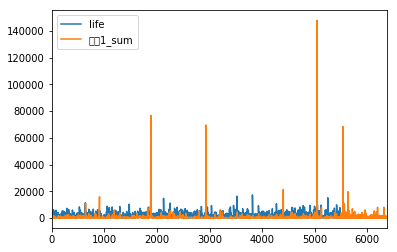

In [29]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
train_test[['life','告警1_sum']].plot()
plt.show()

In [101]:
for i in train_test['life']:
    if i >200000:
        print(i)

1638375.0
1638375.0
1638375.0
1638375.0
1638375.0
1638375.0
